In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm 

import seaborn as sns

# Add the 'src' directory to the Python path
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Importing the data and splitting into train and test

In [2]:
data = pd.read_pickle('Data.pickle')

X = np.array(data.iloc[:, :-1])
target = np.array(data.iloc[:, -1]).reshape(-1, 1)

In [3]:
# Splitting into training and test set, with the first 80% as training and last 20% as test

tot_n_inputs = X.shape[0]
num_features = X.shape[-1]

train_size = 0.8
index_train_end = int(tot_n_inputs*train_size)

X_train, X_test = X[0:index_train_end,:], X[index_train_end:tot_n_inputs,:]
y_train, y_test = target[0:index_train_end], target[index_train_end:]

In [4]:
# Scaling the data

# Using scikit-learns StandardScaler
x_scaler = StandardScaler()

# Fit the scaler on the training data
x_scaler.fit(X_train)

# Transform the training data
X_train_scaled = x_scaler.transform(X_train)

# Transform the test data
X_test_scaled = x_scaler.transform(X_test)

# Transform all the data
X_all_scaled = x_scaler.transform(X)


y_scaler = StandardScaler()

# Fit the scaler on the training target
y_scaler.fit(y_train)

# Transform the training target
y_train_scaled = y_scaler.transform(y_train)

# Setting up design matrix using sliding window

In [5]:
def create_sliding_window(data, target, window_size):
    
    num_samples = len(data) - window_size + 1
    num_features = data.shape[1]
    X = np.zeros((num_samples, window_size, num_features))
    y = np.zeros((num_samples, 1))

    for i in range(num_samples):
        X[i] = data[i:i+window_size]
        y[i] = target[i+window_size-1, :]  # Assuming the target variable is in the first column

    return X, y


# Setting up grid search for finding best hyperparameters for RNN

In [30]:
def create_rnn_model(units=32, activation='relu', learning_rate=0.01, lmbd=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=units, activation=activation, input_shape=(None, num_features),
                        kernel_regularizer=l2(lmbd)))

    model.add(Dense(1, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))
    
    return model

In [7]:
# Wrapping the model with KerasRegressor, since it is a regression problem
grid_search_model = KerasRegressor(model=create_rnn_model, verbose=0)

In [8]:
# Setting up the parameter grid to search through
param_grid = {
    'model__units': [16, 32, 64],
    'model__activation': ['sigmoid', 'tanh', 'relu', 'leaky_relu'],
    'model__learning_rate': np.logspace(-4, -1, 4), 
    'model__lmbd': np.logspace(-4, -1, 4)
}

# Testing different window sizes

In [24]:
window_sizes = [10, 20, 30] # Number of timesteps to include in each sliding window

grid = GridSearchCV(estimator=grid_search_model, param_grid=param_grid, n_jobs=-1, cv=3)

mse = {}
r2 = {}
best_params = {}

for window_size in window_sizes:
    # Setting up the design matrix and target values using sliding window
    X_train_sw, y_train_sw = create_sliding_window(X_train_scaled, y_train_scaled, window_size)
    X_test_sw, y_test_sw = create_sliding_window(X_test_scaled, y_test, window_size)
    
    # Performing a grid search to find best hyperparameter values
    grid_result = grid.fit(X_train_sw, y_train_sw)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    best_params[window_size] = grid_result.best_params_
    
    units = grid_result.best_params_['model__units']
    activation = grid_result.best_params_['model__activation']
    learning_rate = grid_result.best_params_['model__learning_rate']
    lmbd = grid_result.best_params_['model__lmbd']
    
    model = create_rnn_model(units, activation, learning_rate, lmbd)
    
    model.fit(X_train_sw, y_train_sw, epochs=100, batch_size=16, verbose=2)
    prediction_test_scaled = model.predict(X_test_sw)
    prediction_test = y_scaler.inverse_transform(prediction_test_scaled)  
    
    try:
        mse[window_size] = mean_squared_error(y_test_sw[:, 0], prediction_test[:, 0])
        r2[window_size] = r2_score(y_test_sw[:, 0], prediction_test[:, 0])
    except ValueError:
        mse[window_size] = np.nan
        r2[window_size] = np.nan
        
print(mse)
print(r2)

C:\Users\vildesn\Anaconda3\envs\fysstk4155\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [ 8.43259080e-01  9.14888639e-01  9.56539349e-01  8.31990280e-01
  9.18776253e-01  9.52645119e-01  7.49686026e-01  9.37110806e-01
  9.54485106e-01  7.84077019e-01  9.25833282e-01  9.54135569e-01
  9.68806438e-01  9.76105528e-01  9.80701045e-01  9.66939614e-01
  9.78200638e-01  9.82242479e-01  9.78027086e-01  9.78455385e-01
  9.80006752e-01  9.68490405e-01  9.66008680e-01  9.51896149e-01
  9.76068748e-01  9.68057275e-01  9.77912816e-01  9.79404532e-01
  9.75087979e-01  9.80222802e-01  9.73597891e-01  9.74299144e-01
  9.70245496e-01  9.69104326e-01  9.64338660e-01  9.61812295e-01
  9.61041349e-01  9.63234640e-01  9.59750663e-01  9.61116251e-01
  9.66062214e-01  9.61653313e-01  9.53815906e-01  9.54759121e-01
  9.45916143e-01  9.11392035e-01  9.39028957e-01  9.47477697e-01
  9.18988003e-01  9.53423943e-01  9.64693820e-01  9.0430731

Best: 0.987624 using {'model__activation': 'relu', 'model__learning_rate': 0.001, 'model__lmbd': 0.1, 'model__units': 64}
Epoch 1/100
5860/5860 - 11s - loss: 0.0463 - 11s/epoch - 2ms/step
Epoch 2/100
5860/5860 - 10s - loss: 0.0142 - 10s/epoch - 2ms/step
Epoch 3/100
5860/5860 - 10s - loss: 0.0137 - 10s/epoch - 2ms/step
Epoch 4/100
5860/5860 - 10s - loss: 0.0134 - 10s/epoch - 2ms/step
Epoch 5/100
5860/5860 - 10s - loss: 0.0129 - 10s/epoch - 2ms/step
Epoch 6/100
5860/5860 - 10s - loss: 0.0127 - 10s/epoch - 2ms/step
Epoch 7/100
5860/5860 - 10s - loss: 0.0127 - 10s/epoch - 2ms/step
Epoch 8/100
5860/5860 - 10s - loss: 0.0124 - 10s/epoch - 2ms/step
Epoch 9/100
5860/5860 - 10s - loss: 0.0124 - 10s/epoch - 2ms/step
Epoch 10/100
5860/5860 - 10s - loss: 0.0123 - 10s/epoch - 2ms/step
Epoch 11/100
5860/5860 - 10s - loss: 0.0121 - 10s/epoch - 2ms/step
Epoch 12/100
5860/5860 - 10s - loss: 0.0120 - 10s/epoch - 2ms/step
Epoch 13/100
5860/5860 - 10s - loss: 0.0121 - 10s/epoch - 2ms/step
Epoch 14/100
586

C:\Users\vildesn\Anaconda3\envs\fysstk4155\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [ 8.12144137e-01  9.40257365e-01  9.46354089e-01  7.38954452e-01
  9.23904682e-01  9.52411319e-01  8.38907926e-01  9.17335320e-01
  9.56388255e-01  7.56538149e-01  8.81242863e-01  9.49749849e-01
  9.68567024e-01  9.71833152e-01  9.81865338e-01  9.69835331e-01
  9.78755072e-01  9.83643723e-01  9.80543532e-01  9.79530843e-01
  9.76646663e-01  9.69019581e-01  9.61036829e-01  9.63328369e-01
  9.75810532e-01  9.74150460e-01  9.83585399e-01  9.79721044e-01
  9.72646581e-01  9.72321728e-01  9.75626099e-01  9.77013150e-01
  9.77769269e-01  9.72027795e-01  9.49905079e-01  9.47496803e-01
  9.59623428e-01  9.57643271e-01  9.45639372e-01  9.60144334e-01
  9.65921803e-01  9.40518635e-01  9.43339956e-01  9.48957172e-01
  9.41733262e-01  9.27028106e-01  9.39665513e-01  5.90048393e-01
  9.08150007e-01  9.33863066e-01  9.62665069e-01  8.8331907

Best: 0.988521 using {'model__activation': 'leaky_relu', 'model__learning_rate': 0.001, 'model__lmbd': 0.01, 'model__units': 32}
Epoch 1/100
5860/5860 - 19s - loss: 0.0316 - 19s/epoch - 3ms/step
Epoch 2/100
5860/5860 - 15s - loss: 0.0106 - 15s/epoch - 3ms/step
Epoch 3/100
5860/5860 - 15s - loss: 0.0098 - 15s/epoch - 3ms/step
Epoch 4/100
5860/5860 - 15s - loss: 0.0096 - 15s/epoch - 3ms/step
Epoch 5/100
5860/5860 - 19s - loss: 0.0094 - 19s/epoch - 3ms/step
Epoch 6/100
5860/5860 - 16s - loss: 0.0093 - 16s/epoch - 3ms/step
Epoch 7/100
5860/5860 - 15s - loss: 0.0090 - 15s/epoch - 3ms/step
Epoch 8/100
5860/5860 - 15s - loss: 0.0089 - 15s/epoch - 3ms/step
Epoch 9/100
5860/5860 - 16s - loss: 0.0088 - 16s/epoch - 3ms/step
Epoch 10/100
5860/5860 - 16s - loss: 0.0087 - 16s/epoch - 3ms/step
Epoch 11/100
5860/5860 - 16s - loss: 0.0086 - 16s/epoch - 3ms/step
Epoch 12/100
5860/5860 - 15s - loss: 0.0086 - 15s/epoch - 3ms/step
Epoch 13/100
5860/5860 - 15s - loss: 0.0085 - 15s/epoch - 3ms/step
Epoch 14/

C:\Users\vildesn\Anaconda3\envs\fysstk4155\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [ 8.16855100e-01  9.13861651e-01  9.60483779e-01  8.26573218e-01
  9.09848037e-01  9.56446127e-01  7.79177001e-01  9.31147772e-01
  9.57701066e-01  7.46296606e-01  9.05998655e-01  9.57583389e-01
  9.67162549e-01  9.73554026e-01  9.81021442e-01  9.72219689e-01
  9.76421230e-01  9.83342421e-01  9.76481975e-01  9.80995795e-01
  9.81754968e-01  9.69567421e-01  9.69566850e-01  9.62872022e-01
  9.82289565e-01  9.82692433e-01  9.85949013e-01  9.81804327e-01
  9.83483401e-01  9.76963267e-01  9.79872986e-01  9.80302722e-01
  9.72761111e-01  9.72953834e-01  9.77936287e-01  9.49110889e-01
  9.52652409e-01  9.58581011e-01  9.54214245e-01  9.58398319e-01
  9.62873338e-01  9.57535156e-01  9.54392490e-01  9.48440918e-01
  9.57445987e-01  9.59602918e-01  9.48962280e-01  9.21318874e-01
  8.95782657e-01  9.45596338e-01  9.64926323e-01  9.0414949

Best: 0.988325 using {'model__activation': 'leaky_relu', 'model__learning_rate': 0.001, 'model__lmbd': 0.01, 'model__units': 64}
Epoch 1/100
5859/5859 - 27s - loss: 0.0267 - 27s/epoch - 5ms/step
Epoch 2/100
5859/5859 - 29s - loss: 0.0107 - 29s/epoch - 5ms/step
Epoch 3/100
5859/5859 - 29s - loss: 0.0098 - 29s/epoch - 5ms/step
Epoch 4/100
5859/5859 - 27s - loss: 0.0095 - 27s/epoch - 5ms/step
Epoch 5/100
5859/5859 - 27s - loss: 0.0095 - 27s/epoch - 5ms/step
Epoch 6/100
5859/5859 - 24s - loss: 0.0090 - 24s/epoch - 4ms/step
Epoch 7/100
5859/5859 - 28s - loss: 0.0089 - 28s/epoch - 5ms/step
Epoch 8/100
5859/5859 - 29s - loss: 0.0088 - 29s/epoch - 5ms/step
Epoch 9/100
5859/5859 - 29s - loss: 0.0088 - 29s/epoch - 5ms/step
Epoch 10/100
5859/5859 - 31s - loss: 0.0088 - 31s/epoch - 5ms/step
Epoch 11/100
5859/5859 - 30s - loss: 0.0088 - 30s/epoch - 5ms/step
Epoch 12/100
5859/5859 - 22s - loss: 0.0088 - 22s/epoch - 4ms/step
Epoch 13/100
5859/5859 - 23s - loss: 0.0084 - 23s/epoch - 4ms/step
Epoch 14/

Window size of 20 seemed to give best result

In [26]:
best_params

{10: {'model__activation': 'relu',
  'model__learning_rate': 0.001,
  'model__lmbd': 0.1,
  'model__units': 64},
 20: {'model__activation': 'leaky_relu',
  'model__learning_rate': 0.001,
  'model__lmbd': 0.01,
  'model__units': 32},
 30: {'model__activation': 'leaky_relu',
  'model__learning_rate': 0.001,
  'model__lmbd': 0.01,
  'model__units': 64}}

# Setting up the actual model

In [31]:
units = 32
activation = "leaky_relu"
learning_rate = 0.001
lmbd = 0.01

window_size = 20

X_train_sw, y_train_sw = create_sliding_window(X_train_scaled, y_train_scaled, window_size)
X_test_sw, y_test_sw = create_sliding_window(X_test_scaled, y_test, window_size)

model_final = create_rnn_model(units, activation, learning_rate, lmbd)
model_final.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_22 (SimpleRNN)   (None, 32)                1248      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_final.fit(X_train_sw, y_train_sw, epochs=100, batch_size=16, verbose=2)

prediction_test_scaled = model_final.predict(X_test_sw)
prediction_test = y_scaler.inverse_transform(prediction_test_scaled)  


Epoch 1/100
5860/5860 - 10s - loss: 0.0323 - 10s/epoch - 2ms/step
Epoch 2/100
5860/5860 - 12s - loss: 0.0106 - 12s/epoch - 2ms/step
Epoch 3/100
5860/5860 - 14s - loss: 0.0098 - 14s/epoch - 2ms/step
Epoch 4/100
5860/5860 - 14s - loss: 0.0095 - 14s/epoch - 2ms/step
Epoch 5/100
5860/5860 - 14s - loss: 0.0093 - 14s/epoch - 2ms/step
Epoch 6/100
5860/5860 - 13s - loss: 0.0091 - 13s/epoch - 2ms/step
Epoch 7/100
5860/5860 - 13s - loss: 0.0089 - 13s/epoch - 2ms/step
Epoch 8/100
5860/5860 - 12s - loss: 0.0089 - 12s/epoch - 2ms/step
Epoch 9/100
5860/5860 - 12s - loss: 0.0088 - 12s/epoch - 2ms/step
Epoch 10/100
5860/5860 - 12s - loss: 0.0088 - 12s/epoch - 2ms/step
Epoch 11/100
5860/5860 - 13s - loss: 0.0086 - 13s/epoch - 2ms/step
Epoch 12/100
5860/5860 - 13s - loss: 0.0086 - 13s/epoch - 2ms/step
Epoch 13/100
5860/5860 - 13s - loss: 0.0086 - 13s/epoch - 2ms/step
Epoch 14/100
5860/5860 - 14s - loss: 0.0084 - 14s/epoch - 2ms/step
Epoch 15/100
5860/5860 - 13s - loss: 0.0085 - 13s/epoch - 2ms/step
Epoc

In [33]:
mse_final = mean_squared_error(y_test_sw[:, 0], prediction_test[:, 0])
r2_final = r2_score(y_test_sw[:, 0], prediction_test[:, 0])

print(f"MSE test: {mse_final}")
print(f"R^2 test: {r2_final}")

MSE test: 1.9732572077561086
R^2 test: 0.9896543559705813


In [34]:
prediction_train_scaled = model_final.predict(X_train_sw)
prediction_train = y_scaler.inverse_transform(prediction_train_scaled)

trainScore = model_final.evaluate(X_train_sw, y_train_sw, verbose=0)
print(f"Train score: {trainScore}")

mse_final_train = mean_squared_error(y_train[(window_size-1):, 0], prediction_train[:, 0])
r2_final_train = r2_score(y_train[(window_size-1):, 0], prediction_train[:, 0])

print(f"MSE train: {mse_final_train}")
print(f"R^2 train: {r2_final_train}")

2930/2930 [==============================] - 5s 2ms/step
Train score: 0.00700622983276844
MSE train: 1.0994568157259421
R^2 train: 0.9940140462004753


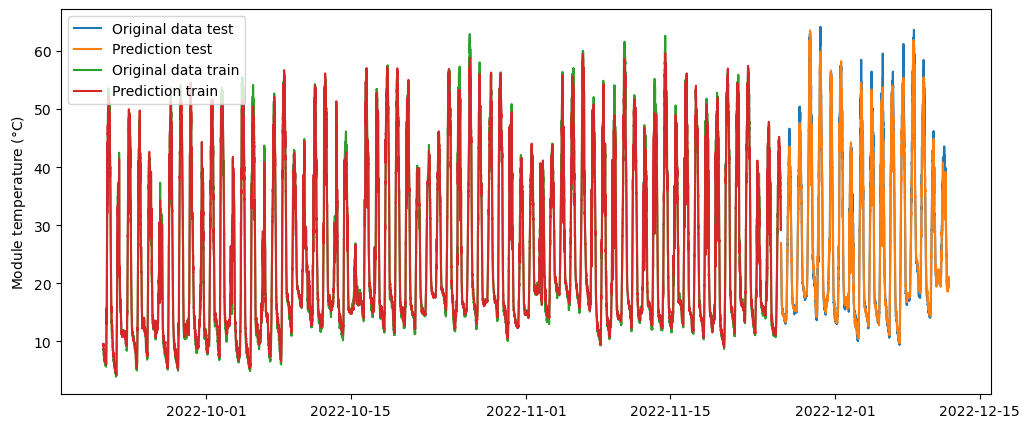

In [47]:
index_train = data.iloc[(window_size-1):index_train_end].index
index_test = data.iloc[(index_train_end+(window_size-1)):].index

plt.figure(figsize=(12, 5))

plt.plot(index_test, y_test[(window_size-1):, 0], label="Original data test")
plt.plot(index_test, prediction_test[:, 0], label="Prediction test")

plt.plot(index_train, y_train[(window_size-1):, 0], label="Original data train")
plt.plot(index_train, prediction_train[:, 0], label="Prediction train")

plt.ylabel(r"Module temperature ($\degree$C)")

plt.legend()

plt.savefig(r"Figures\RNN\Plot_of_predicted_and_original_data_all_data.png")

plt.show()

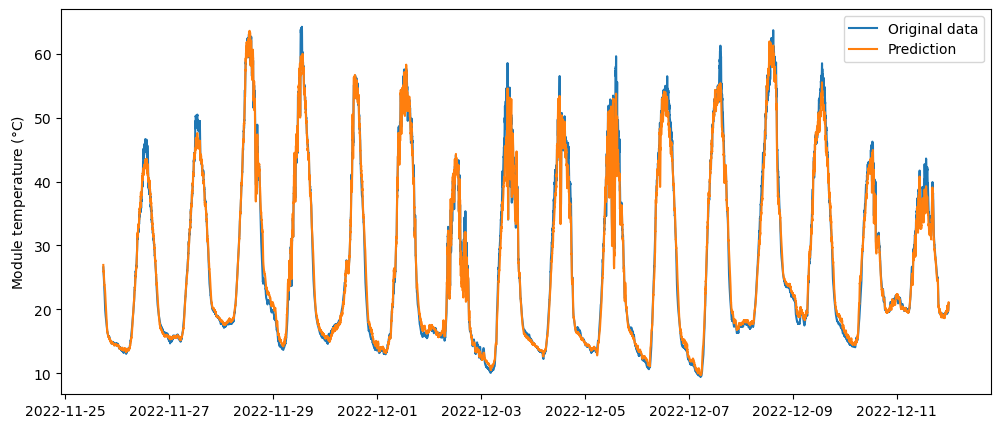

In [46]:
# Only plotting test

plt.figure(figsize=(12, 5))

plt.plot(index_test, y_test[(window_size-1):, 0], label="Original data")

plt.plot(index_test, prediction_test[:, 0], label="Prediction")

plt.ylabel(r"Module temperature ($\degree$C)")

plt.legend()

plt.savefig(r"Figures\RNN\Plot_of_predicted_and_original_data_testset.png")

plt.show()